In [27]:
import pandas as pd
import numpy as np
import pickle
import nltk
import os
import boto3
import re
import json
import xgboost as xgb
import sklearn
import matplotlib.pyplot as plt
import optuna
import seaborn as sns

from sklearn.metrics import (
    precision_recall_curve, roc_auc_score, auc, roc_curve, average_precision_score
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from optuna.samplers import TPESampler
from catboost import CatBoostClassifier, Pool
from text_ngram import TextNgramFeatureGenerator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('stopwords')
from nltk.corpus import stopwords
from IPython.display import display
pd.options.display.max_columns = None

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laml2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Preprocess Data

In [2]:
raw_english_stopwords = list(stopwords.words('english'))
raw_english_stopwords.extend(['the', 'non', 'than', 'for', 'not', 'at', 'as', 'use'])
english_stopwords = ['__nlp__.' + word for word in raw_english_stopwords]

In [3]:
#read data
train_data = pd.read_csv('train_new_nlp_chf_90daysprior.csv')
test_data = pd.read_csv('test_new_nlp_chf_90daysprior.csv')

In [4]:
def preprocess_data(train_data, test_data):

    #convert data type
    train_data[['ICD_CATEGORY_LIST', 'PHARMACY_LIST', 'LAB_LIST']] = train_data[
        ['ICD_CATEGORY_LIST', 'PHARMACY_LIST', 'LAB_LIST']
    ].astype(str)
    test_data[['ICD_CATEGORY_LIST', 'PHARMACY_LIST', 'LAB_LIST']] = test_data[
        ['ICD_CATEGORY_LIST', 'PHARMACY_LIST', 'LAB_LIST']
    ].astype(str)

    #count vectorizer
    vectorizer = CountVectorizer(
        min_df=30,
        ngram_range=(1, 3),
        max_features=3000,
        dtype=np.uint8,
        stop_words=raw_english_stopwords,
    ) #TfidfVectorizer #CountVectorizer

    # TextNgramFeatureGenerator
    text_feature_generator = TextNgramFeatureGenerator(
        text_columns=['ICD_CATEGORY_LIST', 'PHARMACY_LIST', 'LAB_LIST'],
        max_memory_ratio=0.85,
        vectorizer=vectorizer
    )

    train_nlp_features, type_data = text_feature_generator._fit_transform(train_data)

    test_nlp_features = text_feature_generator._transform(test_data)

    # NLP features
    train_data_all_fea = pd.concat([train_data, train_nlp_features], axis=1)
    
    test_data_all_fea = pd.concat([test_data, test_nlp_features], axis=1)

    train_data_all_fea = train_data_all_fea.drop(
        columns=['ICD_CATEGORY_LIST', 'PHARMACY_LIST', 'LAB_LIST']
    )
    
    test_data_all_fea = test_data_all_fea.drop(
        columns=['ICD_CATEGORY_LIST', 'PHARMACY_LIST', 'LAB_LIST']
    )

    return train_data_all_fea, test_data_all_fea


In [5]:
train, test = preprocess_data(train_data, test_data)


20 Fitting CountVectorizer for text features: ['ICD_CATEGORY_LIST', 'PHARMACY_LIST', 'LAB_LIST'] 	
15 CountVectorizer(dtype=<class 'numpy.uint8'>, max_features=3000, min_df=30,
                ngram_range=(1, 3),
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...]) 		
20 CountVectorizer fit with vocabulary size = 3000 	


In [6]:
train.to_csv('train_data_tab_and_nlp_tfidffea3000_hipknee_90daysprior_numNoScale.csv', index=False)
test.to_csv('test_data_tab_and_nlp_tfidffea3000_hipknee_90daysprior_numNoScale.csv', index=False)

# 2. Exploratory Data Analysis

In [8]:
# read data
test_data = pd.read_csv('test_data_tab_and_nlp_tfidffea3000_hipknee_90daysprior_numNoScale.csv')
train_data = pd.read_csv('train_data_tab_and_nlp_tfidffea3000_hipknee_90daysprior_numNoScale.csv')

In [10]:
print(train_data.shape)
print(test_data.shape)

(185157, 3005)
(83575, 3005)


In [11]:
# train:test ratio

train_test_ratio = train_data.shape[0]/(train_data.shape[0] + test_data.shape[0])
print(train_test_ratio)
# 70% train- 30% test >> reasonable ratio

0.6890024262090112


In [12]:
train_data.head()

TARGET GENDER   MBR_MER  AGE  __nlp__.100  __nlp__.100 leukocytes  \
0       1      F  0.302006   73           11                      11   
1       1      F  4.635629   85           25                      25   
2       1      M  3.349411   65            0                       0   
3       1      F  0.000000   65            0                       0   
4       1      F  0.137626   80            5                       5   

   __nlp__.100 leukocytes alanine  __nlp__.100 leukocytes alkaline  \
0                               1                                0   
1                               0                                0   
2                               0                                0   
3                               0                                0   
4                               0                                0   

   __nlp__.100 leukocytes aspartate  __nlp__.100 leukocytes basophils  \
0                                 0                                 0   
1                                 1                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 1   

   __nlp__.100 leukocytes calcium  __nlp__.100 leukocytes carbon  \
0                               0                              0   
1                               1                              0   
2                               0                              0   
3                               0                              0   
4                               1                              1   

   __nlp__.100 leukocytes chloride  __nlp__.100 leukocytes cholesterol  \
0                                0                                   0   
1                                1                                   0   
2                                0                                   0   
3                                0                                   0   
4                                0                                   0   

   __nlp__.100 leukocytes creatinine  __nlp__.100 leukocytes eosinophils  \
0                                  0                                   0   
1                                  1                                   1   
2                                  0                                   0   
3                                  0                                   0   
4                                  0                                   0   

   __nlp__.100 leukocytes erythrocyte  __nlp__.100 leukocytes glomerular  \
0                                   1                                  0   
1                                   3                                  0   
2                                   0                                  0   
3                                   0                                  0   
4                                   0                                  0   

   __nlp__.100 leukocytes glucose  __nlp__.100 leukocytes granulocytes  \
0                               1                                    0   
1                               2                                    0   
2                               0                                    0   
3                               0                                    0   
4                               0                                    0   

   __nlp__.100 leukocytes hemoglobin  __nlp__.100 leukocytes lymphocytes  \
0                                  2                                   0   
1                                  1                                   0   
2                                  0                                   0   
3                                  0                                   0   
4                                  1                                   0   

   __nlp__.100 leukocytes monocytes  __n

In [13]:
# TARGET DISTRIBUTION

### Absolute counts
abs_counts = train_data["TARGET"].value_counts()

### Percentages
pct_counts = train_data["TARGET"].value_counts(normalize=True) * 100

### Combine into one DataFrame
target_summary = pd.DataFrame({
    "Count": abs_counts,
    "Percentage": pct_counts.round(2)
})

print(target_summary)

         Count  Percentage
TARGET                    
0       140728        76.0
1        44429        24.0


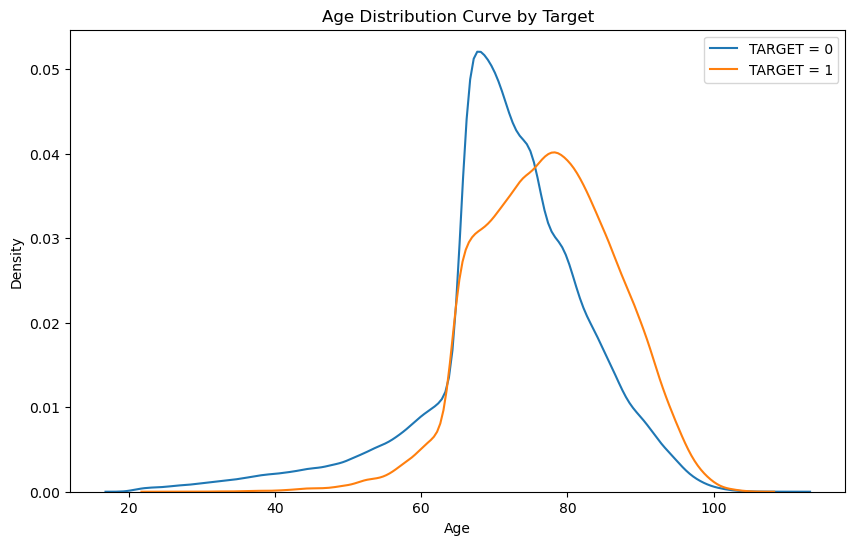

   TARGET        AGE
0       0  71.766102
1       1  77.319363


In [14]:
# AGE DISTRIBUTION

### histogram with KDE overlay
plt.figure(figsize=(10,6))

### plot only KDE curves
sns.kdeplot(data=train_data[train_data['TARGET']==0], x='AGE', label='TARGET = 0', fill=False)
sns.kdeplot(data=train_data[train_data['TARGET']==1], x='AGE', label='TARGET = 1', fill=False)

plt.title("Age Distribution Curve by Target")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.show()

### calculate median age by TARGET group
mean_age = train_data.groupby("TARGET")["AGE"].mean().reset_index()
print(mean_age)

# CHF cohort is older

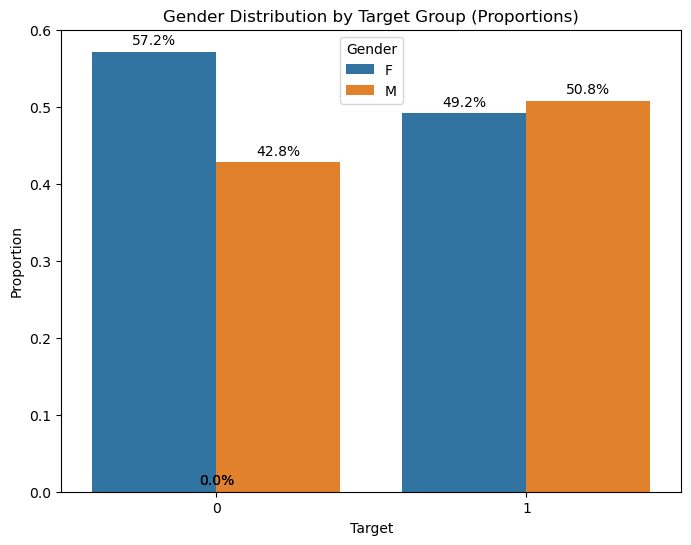

In [15]:
# GENDER DISTRIBUTION

gender_dist = (
    train_data.groupby(["TARGET", "GENDER"])
    .size()
    .reset_index(name="count")
)

### calculate proportion within each target group
gender_dist["proportion"] = (
    gender_dist.groupby("TARGET")["count"].transform(lambda x: x / x.sum())
)

### plot
plt.figure(figsize=(8,6))
ax = sns.barplot(data=gender_dist, x="TARGET", y="proportion", hue="GENDER")

# add labels
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):   # avoid labeling missing bars
        ax.annotate(f"{height:.1%}",               # format as percentage
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=10, color='black', xytext=(0, 3),
                    textcoords='offset points')

plt.title("Gender Distribution by Target Group (Proportions)")
plt.xlabel("Target")
plt.ylabel("Proportion")
plt.legend(title="Gender")
plt.show()

# males are more likely to get CHF

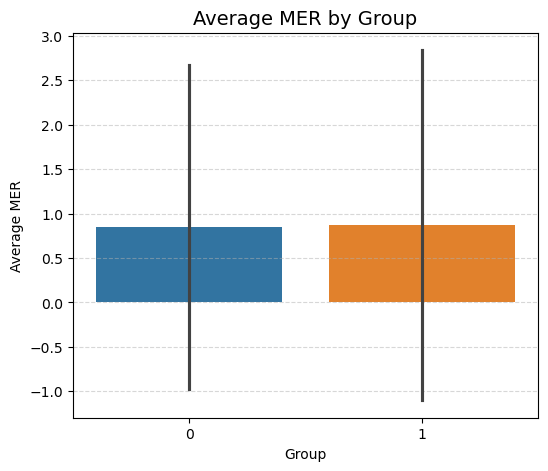

TARGET
0    0.847604
1    0.869119
Name: MBR_MER, dtype: float64

In [16]:
#MER

plt.figure(figsize=(6,5))

sns.barplot(data=train_data, x='TARGET', y='MBR_MER', hue='TARGET', errorbar='sd', legend = False)

plt.title('Average MER by Group', fontsize=14)
plt.xlabel('Group')
plt.ylabel('Average MER')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# calculate average MER
train_data.groupby('TARGET')['MBR_MER'].mean()

# CHF cohort is more expensive 

In [63]:
# Chronic Conditions
upmc_dsn = "xxxxxxxxxxx"
upmc_port = 'xxxxxxx'
upmc_service_name= "xxxxxxxxxx"
upmc_user = "xxxxxxx"
upmc_password = "xxxxxxxxxx"
import oracledb

dsn_tns = oracledb.makedsn(upmc_dsn, upmc_port, service_name=upmc_service_name) 
conn = oracledb.connect(user=upmc_user, password=upmc_password, dsn=dsn_tns)

with conn.cursor() as cursor:
    cursor.execute('''
    with all_mbrs_cte as (
        select MEMBER_NBR, EVENT_DATE, SERVICE_MONTH, '1' as TARGET
        from  MC_SNP_USER.LL_CHF_MC_MBRS 
        union all
        select MEMBER_NBR, EVENT_DATE, SERVICE_MONTH, '0' as TARGET
        from  MC_SNP_USER.LL_CHF_MC_NON_MBRS) 

     SELECT t0.MEMBER_NBR, EVENT_DATE, SERVICE_MONTH, TARGET, MEMBERSHIP_MONTH, 
            CC_ASTHMA, CC_ATRIAL_FIBRILLATION, CC_CAD, CC_CENTRAL_NERV_SYS_DISEASE, CC_CEREBRAL_PALSY, CC_CEREBRO_VASCULAR_DISEASE, CC_CHF, 
            CC_CHRONIC_HEPATITIS, CC_COAGULATION_DEFECTS, CC_COPD, CC_CYSTIC_FIBROSIS, CC_DM, CC_EPILEPSY,
            CC_ESRD, CC_HEMATOLOGICAL_SICKLE_CELL, CC_HIV, CC_HYPERLIPIDEMIA, CC_HYPERTENSION, CC_IMMUNE_DEFICIENCY,
            CC_INFLAMMATORY_BOWEL_DISEASE, CC_LIVER_DISEASE, CC_LUPUS_CONN_TISSUE_DISORDERS, CC_MIGRAINE, CC_MORBID_OBESITY, CC_MULTIPLE_SCLEROSIS,
            CC_MUSCULAR_DYSTROPHY, CC_MYASTHENIA_GRAVIS, CC_NEOPLASM_MALIGNANT, CC_OSTEOARTHRITIS, CC_OSTEOPOROSIS, 
            CC_PANCREATITIS_CHRONIC, CC_PARALYSIS, CC_PARKINSONS_DISEASE, CC_RENAL_DISEASE, CC_RHEUMA_ARTHRITIS, CC_SCI, CC_SPINA_BIFIDA, CC_TRANSPLANT,
            MH_ADHD, MH_ADJUSTMENT, MH_ANXIETY, MH_AUTISTIC_SPECTRUM_DISORDER, MH_BIPOLAR_DISORDER, MH_CHILDHOOD_DISORDER, MH_DEMENTIA, 
            MH_DEPRESSION_MAJOR, MH_DEPRESSION_OTHER, MH_DISSOCIATIVE_DISORDER, MH_DYSTHYMIA, MH_EATING_DISORDER, MH_EPISODIC_MOOD_DISORDER, MH_FACTITIOUS,
            MH_IMPULSE, MH_INTELLECTUAL_DISABILITY, MH_ORGANIC_MENTAL_DISORDER, MH_OTHER_NONORGANIC_PSYCHOSES, MH_PARANOID_STATES, 
            MH_PERSONALITY_DISORDER, MH_PTSD, MH_SCHIZOPHRENIA, MH_SEXUAL_DISORDER, MH_SLEEP_DISORDER, MH_SOMATOFORM, MH_SPMI, TOTAL_CC, TOTAL_MH
    FROM all_mbrs_cte t0
    left join 
        (select * from mc_snp_user.mc_hit_final
        union all
         select * from mc_snp_user.snp_hit_final) t1 
    on t0.MEMBER_NBR = t1.MEMBER_NBR 
    where MEMBERSHIP_MONTH >= '2020/01'
 ''')

    from pandas import DataFrame
    chronic_conditions = DataFrame(cursor.fetchall())
    chronic_conditions.columns = [x[0] for x in cursor.description]

In [64]:
### Remove one MEMBER_NBR column
dupes = chronic_conditions.columns.duplicated()
chronic_conditions = chronic_conditions.loc[:, ~dupes]

### Convert SERVICE_MONTH from yyyy/mm → datetime (for comparison)
chronic_conditions["EVENT_MONTH"] = pd.to_datetime(chronic_conditions["EVENT_DATE"], format="%Y/%m")

### Convert MEMBERSHIP_MONTH to datetime 
chronic_conditions["MEMBERSHIP_MONTH"] = chronic_conditions["MEMBERSHIP_MONTH"].astype(str).str[:4] + "/" + chronic_conditions["MEMBERSHIP_MONTH"].astype(str).str[4:6]
chronic_conditions["MEMBERSHIP_MONTH"] = pd.to_datetime(
    chronic_conditions["MEMBERSHIP_MONTH"], format="%Y/%m"
)

### Compute month difference
chronic_conditions["month_diff"] = (
    (chronic_conditions["MEMBERSHIP_MONTH"].dt.year - chronic_conditions["EVENT_MONTH"].dt.year
) * 12 + (
    chronic_conditions["MEMBERSHIP_MONTH"].dt.month - chronic_conditions["EVENT_MONTH"].dt.month)
)

### Keep only SERVICE_MONTH < MEMBERSHIP_MONTH and within 12 months
chronic_conditions_filtered = chronic_conditions[
    (chronic_conditions["month_diff"] > 3) & (chronic_conditions["month_diff"] <= 12)
]

In [65]:
### For each member, pick the one closest (smallest positive month_diff)
chronic_conditions_closest = (
    chronic_conditions_filtered.sort_values(["MEMBER_NBR", "month_diff"])
    .groupby("MEMBER_NBR", as_index=False)
    .first()
)
chronic_conditions_closest = chronic_conditions_closest[["MEMBER_NBR", "TARGET", "TOTAL_CC", "TOTAL_MH"]] 

In [66]:
print(len(chronic_conditions_closest))
print(chronic_conditions_closest['MEMBER_NBR'].nunique())

211179
211179


In [67]:
avg_cc_mh = chronic_conditions_closest.groupby('TARGET')[['TOTAL_CC', 'TOTAL_MH']].mean().reset_index()

avg_cc_mh

,TARGET,TOTAL_CC,TOTAL_MH
0,0,3.988189,0.925592
1,1,6.424764,1.007599


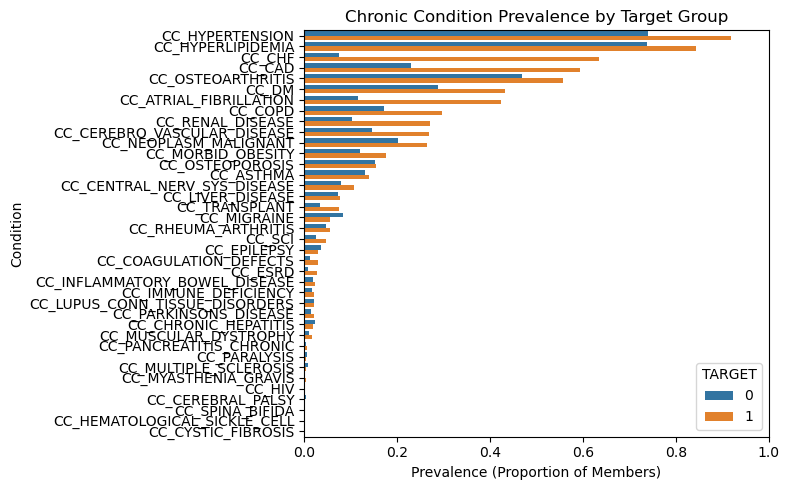

In [68]:
### most prevalent chronic conditions by TARGET = 0 and TARGET = 1

chronic_conditions_long = pd.melt(
    chronic_conditions_filtered,
    id_vars = ['MEMBER_NBR', 'EVENT_DATE', 'SERVICE_MONTH', 'TARGET'],
    value_vars = [ 
        'CC_ASTHMA', 'CC_ATRIAL_FIBRILLATION', 'CC_CAD', 'CC_CENTRAL_NERV_SYS_DISEASE', 'CC_CEREBRAL_PALSY', 'CC_CEREBRO_VASCULAR_DISEASE', 'CC_CHF', 
        'CC_CHRONIC_HEPATITIS', 'CC_COAGULATION_DEFECTS', 'CC_COPD', 'CC_CYSTIC_FIBROSIS', 'CC_DM', 'CC_EPILEPSY',
        'CC_ESRD', 'CC_HEMATOLOGICAL_SICKLE_CELL', 'CC_HIV', 'CC_HYPERLIPIDEMIA', 'CC_HYPERTENSION', 'CC_IMMUNE_DEFICIENCY',
        'CC_INFLAMMATORY_BOWEL_DISEASE', 'CC_LIVER_DISEASE', 'CC_LUPUS_CONN_TISSUE_DISORDERS', 'CC_MIGRAINE', 'CC_MORBID_OBESITY', 'CC_MULTIPLE_SCLEROSIS',
        'CC_MUSCULAR_DYSTROPHY', 'CC_MYASTHENIA_GRAVIS', 'CC_NEOPLASM_MALIGNANT', 'CC_OSTEOARTHRITIS', 'CC_OSTEOPOROSIS', 
        'CC_PANCREATITIS_CHRONIC', 'CC_PARALYSIS', 'CC_PARKINSONS_DISEASE', 'CC_RENAL_DISEASE', 'CC_RHEUMA_ARTHRITIS', 'CC_SCI', 'CC_SPINA_BIFIDA', 'CC_TRANSPLANT'
    ],
    var_name = 'CONDITION',
    value_name = 'HAS_CONDITION'
)

### Compute prevalence by target and condition
prevalence = (
    chronic_conditions_long.groupby(['TARGET', 'CONDITION'])['HAS_CONDITION']
    .mean()
    .reset_index()
)

### Sort conditions by prevalence in TARGET = 1
order = (
    prevalence[prevalence['TARGET'] == '1']
    .sort_values('HAS_CONDITION', ascending=False)['CONDITION']
)

### Plot horizontal bar chart
plt.figure(figsize=(8,5))
sns.barplot(
    data=prevalence,
    y='CONDITION',       # condition on Y axis
    x='HAS_CONDITION',   # prevalence on X axis
    hue='TARGET',        # color by target group
    orient='h',           # make it horizontal
    order = order         # sorted by target = 1 prevalence
)

plt.title('Chronic Condition Prevalence by Target Group')
plt.xlabel('Prevalence (Proportion of Members)')
plt.ylabel('Condition')
plt.xlim(0, 1)
plt.legend(title='TARGET', loc='lower right')
plt.tight_layout()
plt.show()

In [70]:
# Quantify and rank how much each chronic condition differs in prevalence between TARGET = 0 and TARGET = 1

### Pivot to get each target group as a column
diff_df = prevalence.pivot(index='CONDITION', columns='TARGET', values='HAS_CONDITION')

### Rename columns for clarity
diff_df.columns = ['Prevalence_0', 'Prevalence_1']

### Compute difference
diff_df['Difference'] = diff_df['Prevalence_1'] - diff_df['Prevalence_0']

### Sort by ascending difference
diff_df = diff_df.sort_values('Difference', ascending=False).reset_index()

print(diff_df)

                         CONDITION  Prevalence_0  Prevalence_1  Difference
0                           CC_CHF      0.074607      0.634858    0.560251
1                           CC_CAD      0.230892      0.594328    0.363436
2           CC_ATRIAL_FIBRILLATION      0.115562      0.422994    0.307431
3                  CC_HYPERTENSION      0.739812      0.918879    0.179067
4                 CC_RENAL_DISEASE      0.103277      0.270728    0.167450
5                            CC_DM      0.288448      0.432104    0.143656
6                          CC_COPD      0.171544      0.296470    0.124926
7      CC_CEREBRO_VASCULAR_DISEASE      0.146368      0.268689    0.122321
8                CC_HYPERLIPIDEMIA      0.737784      0.843600    0.105816
9                CC_OSTEOARTHRITIS      0.469369      0.556161    0.086792
10           CC_NEOPLASM_MALIGNANT      0.202297      0.264054    0.061757
11               CC_MORBID_OBESITY      0.120805      0.176125    0.055320
12                   CC_T

# 3. MODELLING

In [36]:
def preprocess_data_not_scale_numeric(X_train):
    """Preprocess data by handling categorical columns and scaling numeric columns"""
    if isinstance(X_train, pd.DataFrame):
        # Identify categorical and numeric columns
        categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
        
        # Create preprocessing steps for numeric and categorical data
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
            ],
            remainder='passthrough' 
        )
        
        # Transform the data
        X_train_processed = preprocessor.fit_transform(X_train)
        return X_train_processed, preprocessor
    else:
        # If X is already a numpy array (like from sklearn datasets), just scale it
        scaler = StandardScaler()
        X_train_processed = scaler.fit_transform(X_train)
        return X_train_processed, scaler


In [37]:
# get the X and y
y_train = train_data['TARGET']
X_train = train_data.drop(columns=['TARGET', '__nlp__._total_'])

y_test = test_data['TARGET']
X_test = test_data.drop(columns=['TARGET', '__nlp__._total_'])

# Convert text columns into numeric
X_train_processed, no_scale_preprocessor = preprocess_data_not_scale_numeric(X_train)
X_test_processed = no_scale_preprocessor.transform(X_test)

# Dummify categorical features
X_train_dummies = pd.get_dummies(X_train, columns=['GENDER'], drop_first = True)
X_test_dummies = pd.get_dummies(X_test, columns=['GENDER'], drop_first = True)

In [38]:
# Train different models

## Logistic Regression

log_model = LogisticRegression(
    max_iter=10000,
    class_weight='balanced' 
)
log_model.fit(X_train_processed, y_train)

# (logistic regression) label predictions (no proba)
log_y_pred = log_model.predict_proba(X_test_processed)[:, 1]

In [39]:
# Random Forest

rf_model = RandomForestClassifier(
    n_estimators=100,       # Number of trees
    max_depth=None,         # Tree depth (None = grow until pure)
    random_state=42,        # For reproducibility
    class_weight='balanced' 
)

rf_model.fit(X_train_processed, y_train)

# (random forest) predict proba
rf_y_pred_proba = rf_model.predict_proba(X_test_processed)[:, 1]

In [40]:
# xgboost 

### Compute scale_pos_weight
neg_count = (y_train== 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight_value = neg_count / pos_count #pos_count / neg_count # neg_count / pos_count

### xgb model
xgb_model = xgb.XGBClassifier(
    max_depth=15,
    n_estimators=50,
    scale_pos_weight=scale_pos_weight_value,
    objective='binary:logistic',
    learning_rate=0.3,               # same as eta
    subsample=1,
    colsample_bytree=1,
    min_child_weight=1,
    reg_lambda=1,
    reg_alpha=0,
    verbosity=1,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_processed, y_train)

# predict
xgboost_y_pred_proba = xgb_model.predict_proba(X_test_processed)[:, 1]   # probabilities

C:\Users\laml2\AppData\Local\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:07:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [41]:
#---------------- (catboost) Parameter Tuning with Cross Validation--------------------#
import optuna

def objective(trial, X, y, cv=4):
    # Define the hyperparameters to optimize
    param = {
        'eval_metric': 'AUC',
        'iterations': trial.suggest_int("iterations", 50, 150),
        'learning_rate': trial.suggest_float("learning_rate",  1e-3, 0.05, log=True),
        'depth': trial.suggest_int("depth", 4, 8),
        'verbose': 0,
        'random_seed': 42,
        'allow_writing_files': False,
        'task_type': 'CPU'
    }
    
    # Cross-validation
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    auc_scores = []
    
    for train_idx, valid_idx in skf.split(X, y):
        X_train_fold, X_valid_fold = X[train_idx], X[valid_idx]
        y_train_fold, y_valid_fold = y[train_idx], y[valid_idx]

        train_pool = Pool(X_train_fold, label=y_train_fold)
        valid_pool = Pool(X_valid_fold, label=y_valid_fold)
        
        # Train the model
        model = CatBoostClassifier(**param)
        
        model.fit(
            train_pool,
            eval_set = valid_pool,
            early_stopping_rounds=10,
            use_best_model=True
        )
        
        # Make predictions
        preds = model.predict(valid_pool)
        auc = roc_auc_score(y_valid_fold, preds)
        auc_scores.append(auc)
    
    # Return the negative mean AUC across all folds (since we want to maximize AUC)
    return -np.mean(auc_scores)

    gc.collect()

#Efficient sampling:
# By default, Optuna uses a model-based approach called TPE (Tree Parzen Estimator), 
#a Bayesian optimization based on kernel fitting that after sampling different areas of the search space, 
#focuses its attention on the place where it had the best results and continue to look there.
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = TPESampler(seed=1)


##Create the study
#study = optuna.create_study(direction='minimize')  # We use minimize with negative AUC
#study.optimize(lambda trial: objective(trial, train_x, train_y), n_trials=10,  gc_after_trial=True)




In [42]:
# comment out to save disk. remember to uncomment out in full version
# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='minimize')  # We use minimize with negative AUC
# study.optimize(
#      lambda trial: objective(trial, X_train_processed, y_train),
#      n_trials=15,
#     gc_after_trial=True
#  )

In [43]:
# comment out to save disk. remember to uncomment out in full version
# #Print results
# print('Number of finished trials:', len(study.trials))
# print('Best trial:')
# trial = study.best_trial
# print('  Value (negative AUC):', trial.value)
# print('  AUC:', -trial.value)  # Convert back to positive AUC
# print('  Params:')
# for key, value in trial.params.items():
#     print(f'    {key}: {value}')

# # # Plot optimization history
# # optuna.visualization.matplotlib.plot_optimization_history(study)
# # plt.title('Optimization History')
# # plt.savefig('optimization_history.png')

# # # Plot parameter importances
# # optuna.visualization.matplotlib.plot_param_importances(study)
# # plt.title('Parameter Importances')
# # plt.savefig('param_importances.png')

#trial.params.items()

#best_params_catboost = {
#    iterations = 124,
#    learning_rate = 0.04571438357826491,
#    depth = 5
#}

In [44]:
train_pool = Pool(X_train_processed, y_train)

# Train model on full data
final_model = CatBoostClassifier( 
    iterations = 149,
    learning_rate = 0.048923125327789196,
    depth = 8, 
    verbose = False
)
final_model.fit(train_pool)

# ---- Predict on test set ----
preds = final_model.predict_proba(X_test_processed)[:, 1]   # probabilities
final_auc_catboost = roc_auc_score(y_test, preds)
print(f'Final AUC on test set: {final_auc_catboost:.4f}')

Final AUC on test set: 0.9777


# 4. EVALUATION

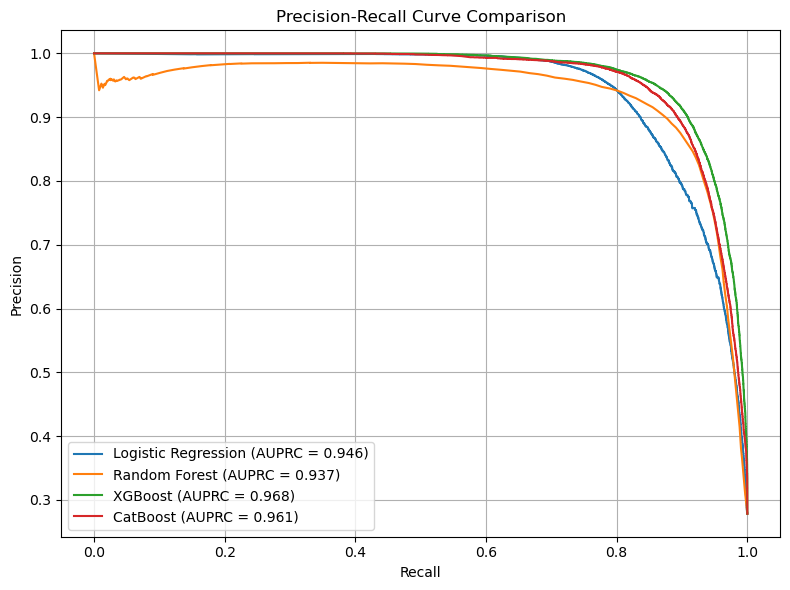

In [45]:
# ------------------------- Precision Recall Curve -----------------------------#

# Compute PR data
precision_lr, recall_lr, _ = precision_recall_curve(y_test, log_y_pred)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_y_pred_proba)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgboost_y_pred_proba)
precision_catboost, recall_catboost, _ = precision_recall_curve(y_test, preds)

# AUPRC scores
auprc_lr = average_precision_score(y_test, log_y_pred)
auprc_rf = average_precision_score(y_test, rf_y_pred_proba)
auprc_xgb = average_precision_score(y_test, xgboost_y_pred_proba)
auprc_catboost = average_precision_score(y_test, preds)


# Plot all PR curves
plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AUPRC = {auprc_lr:.3f})')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUPRC = {auprc_rf:.3f})')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AUPRC = {auprc_xgb:.3f})')
plt.plot(recall_catboost, precision_catboost, label=f'CatBoost (AUPRC = {auprc_catboost:.3f})')

# Labels and formatting
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
#--------------- choose best threshold with highest F1 score------------#

precision, recall, thresholds = precision_recall_curve(y_test, preds)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold (max F1): {best_threshold:.3f}")
print(f"Precision: {precision[best_idx]:.3f}")
print(f"Recall:    {recall[best_idx]:.3f}")
print(f"F1 Score:  {f1_scores[best_idx]:.3f}")

Best Threshold (max F1): 0.339
Precision: 0.915
Recall:    0.882
F1 Score:  0.899


In [60]:
#--------------- PPV score------------#
# Predict labels for each model

y_pred_class_lr = (log_y_pred >= best_threshold).astype(int)
y_pred_class_rf = (rf_y_pred_proba >= best_threshold).astype(int)
y_pred_class_xgb = (xgboost_y_pred_proba >= best_threshold).astype(int)
y_pred_class_catboost = (preds >= best_threshold).astype(int)

models = {
    "Logistic Regression": y_pred_class_lr,
    "Random Forest": y_pred_class_rf,
    "XGBoost": y_pred_class_xgb,
    "Catboost": y_pred_class_catboost
}

# Calculate PPV for each model
ppv_results = []
for model_name, y_pred in models.items():
    ppv = precision_score(y_test, y_pred)
    ppv_results.append({"Model": model_name, "PPV": ppv})

# Create DataFrame
ppv_df = pd.DataFrame(ppv_results)

# Sort by PPV descending
ppv_df = ppv_df.sort_values(by="PPV", ascending=False).reset_index(drop=True)
ppv_df

,Model,PPV
0,Catboost,0.915359
1,Random Forest,0.865911
2,XGBoost,0.858835
3,Logistic Regression,0.673712


Confusion Matrix:
[[58414  1898]
 [ 2737 20526]]


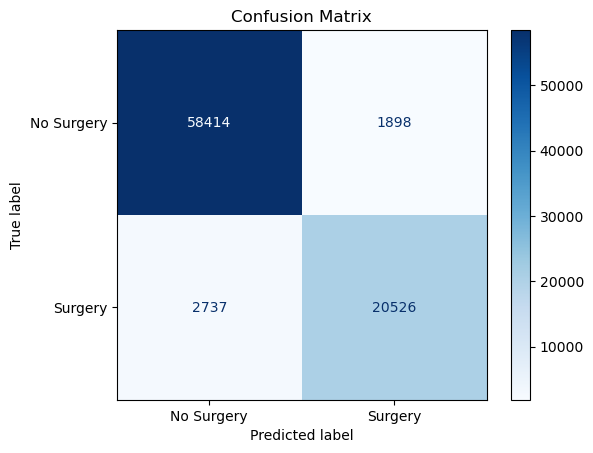

In [47]:
#--------------- confusion matrix------------#

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels (using the best threshold)
preds_class = (preds >= best_threshold).astype(int)

# Compute confusion matrix ----
cm = confusion_matrix(y_test, preds_class)

# Print raw matrix ----
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix ----
display_class = ['No Surgery', 'Surgery']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_class)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# 5. Feature Importance

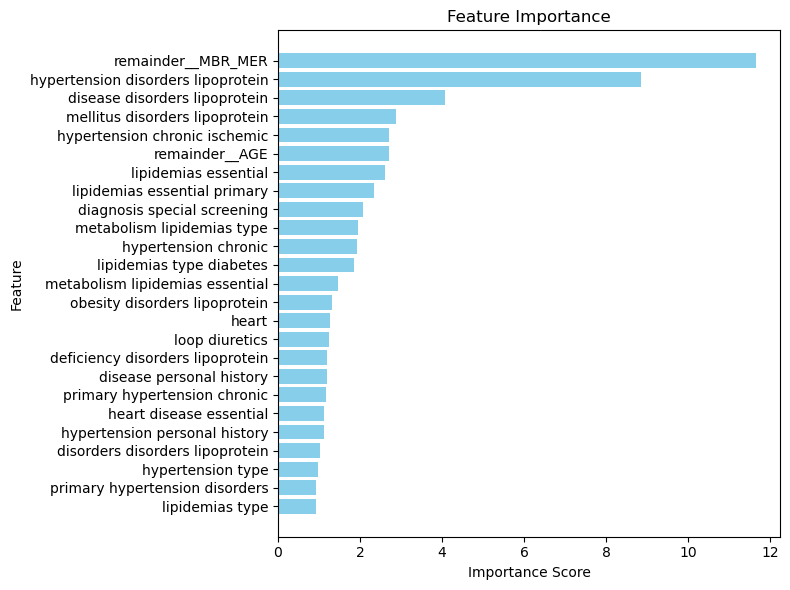

In [61]:
#### (catboost) Map back to get the feature names

### Get list of feature names from pre-processor
feature_name_list = no_scale_preprocessor.get_feature_names_out()
feature_name_list = [
    name.replace("num__","").replace("cat__", "").replace("remainder____nlp__.", "") 
    for name in feature_name_list
]

### Get the feature importance scores with weird/transformed names
raw_importance_score = final_model.get_feature_importance()

### Map the feature scores to the original names
proper_name_importance_score = dict(zip(feature_name_list, raw_importance_score))

### Plot top 20 features to test
num_top_features = 20

### sort the dictionary by values
sorted_items = sorted(proper_name_importance_score.items(), key=lambda item: item[1], reverse=True)
top_25_features = sorted_items[0:25]

### Separate keys and values
keys = [item[0] for item in top_25_features]
keys.reverse()
values = [item[1] for item in top_25_features]
values.reverse()

### Plot the data
plt.figure(figsize=(8, 6))
plt.barh(keys, values, color='skyblue') # Use bar plot for categorical data
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# 6. Member Prediction

In [51]:
import shap

test_pool = Pool(X_test_processed, y_test)

explainer = shap.TreeExplainer(
    final_model,
    feature_names=feature_name_list,
)

### catboost
explanation = explainer(X_test_processed)


In [52]:
### Waterfall plot for a member who is predicted to be likely to have hip knee surgery
fx_values = explanation.base_values + explanation.values.sum(axis=1)

### Find index of the largest f(x)
max_fx_index = np.argmax(fx_values)

print(f"Index of sample with highest f(x): {max_fx_index}")
print(f"Highest f(x): {fx_values[max_fx_index]}")

Index of sample with highest f(x): 17942
Highest f(x): 10.764358623588603


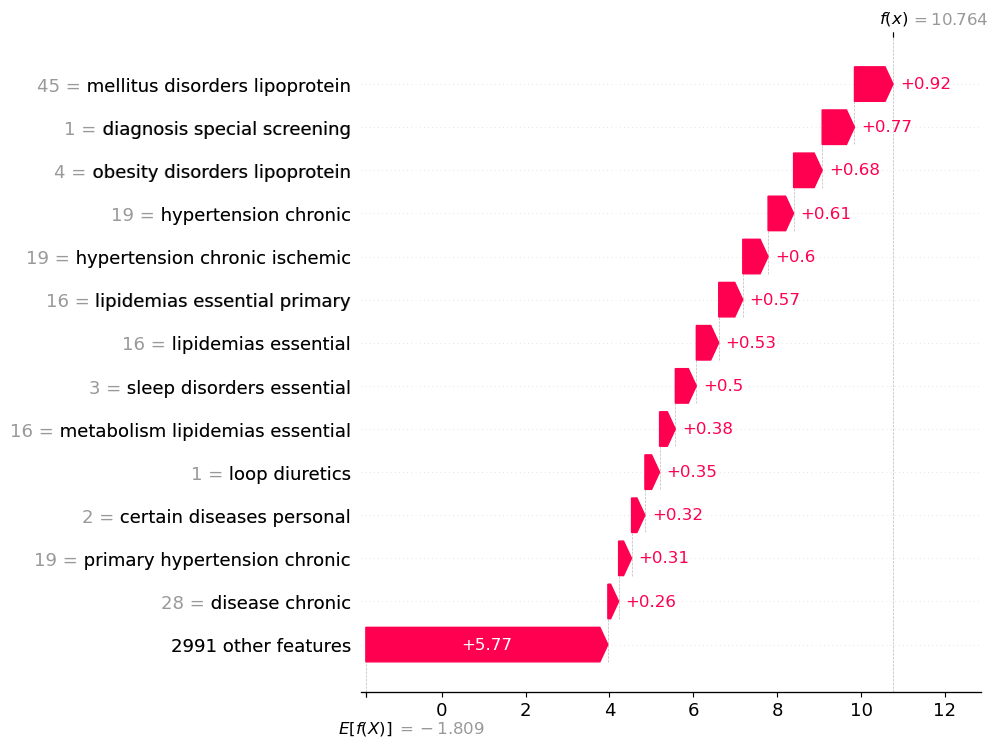

0.9999788607649482 1


In [53]:
### the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
### the number on the left shows the number of occurances of each feature
shap.plots.waterfall(
    explanation[max_fx_index],
    max_display=14
)
print(preds[max_fx_index], y_test[max_fx_index])